<a href="https://colab.research.google.com/github/lipiecki/energy-analytics-2025/blob/main/notebooks/UncertaintyQuantification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uncertainty quantification - from points to distributions

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
import matplotlib.pyplot as plt

### Load one of the included datasets - EPEX or GEFCom

In [2]:
dataset = "epex" # "epex" or "gefcom"
url = f"https://raw.githubusercontent.com/lipiecki/energy-analytics-2025/refs/heads/main/data/{dataset}.csv"
local = f"../data/{dataset}.csv"

In [3]:
df = pd.read_csv(url, delimiter=',', header=0, index_col=[0, 1])
df.head()

price   load_da  load_real  day_of_week
date     hour                                         
20220101 0     50.05  41989.50   43915.50            6
         1     41.33  40105.50   41535.75            6
         2     43.22  38784.00   40480.75            6
         3     45.46  37751.00   39564.00            6
         4     37.67  37877.25   39338.25            6

### Select the starting date and the number of days for the forecasting period

In [4]:
date = 20240513
ndays = 7

### Prepare the explenatory variables for the regression models

In [5]:
# create lag columns for prices from previous days
df['lag1'] = df['price'].shift(24)  # price one day ago (24 hours)
df['lag2'] = df['price'].shift(48)  # price two days ago (48 hours)
df['lag7'] = df['price'].shift(168) # price seven days ago (168 hours)
df.dropna(inplace=True)
df

price   load_da  load_real  day_of_week    lag1    lag2  \
date     hour                                                             
20220108 0     164.17  51093.00   52694.75            6  128.92   99.85   
         1     152.83  49105.50   50532.50            6  118.40  101.32   
         2     166.00  48075.25   49608.25            6  103.01  110.01   
         3     160.86  47763.50   49543.25            6  101.91  111.55   
         4     160.00  47900.25   49077.25            6  101.98  123.37   
...               ...       ...        ...          ...     ...     ...   
20241231 19    200.00  56083.25   54868.50            2  165.93  206.72   
         20    204.61  53423.00   51940.50            2  184.44  194.97   
         21    186.25  50937.50   50559.50            2  203.88  195.95   
         22    146.52  47657.50   49133.50            2  168.46  167.31   
         23    141.68  45257.25   49607.50            2  162.92  149.98   

                 lag7  
date     hour          
20220108 0      50.05  
         1      41.33  
         2      43.22  
         3      45.46  
         4      37.67  
...               ...  
20241231 19    105.66  
         20    102.56  
         21     94.63  
         22     99.04  
         23     90.00  

[26136 rows x 7 columns]

### Select the length of the training window
358 days corresponds to using the data from 365 previous days (due to the 7-day lag)

In [6]:
window = 358

### Select explanatory variables for the model
and cast the data to an array format

In [7]:

X = np.array(df[['lag1', 'lag2', 'lag7', 'load_da']])
Y = np.array(df['price'])

### Generate forecasts using linear regression
AutoRegressive with eXogenuous variables (ARX)

In [8]:
df['arx_forecast'] = np.nan
for i in range(window*24, len(df)):
     # prepare training data
      X_window = X[i-window*24:i:24, :]
      Y_window = Y[i-window*24:i:24]

      # fit the model to training data
      arx = LinearRegression()
      arx = arx.fit(X_window, Y_window)

      # prepare inputs for the next day and hour
      X_next = X[[i], :]

      # predict
      df.iloc[i, df.columns.get_loc('arx_forecast')] = arx.predict(X_next)

### Remove days without forecats

In [9]:
df.dropna(inplace=True)
df

price   load_da  load_real  day_of_week    lag1    lag2  \
date     hour                                                             
20230101 0      -5.17  41792.50   38536.50            7   -0.03   11.17   
         1      -1.07  39621.00   37935.50            7   -0.07    5.09   
         2      -1.47  38240.75   37103.25            7   -0.03    3.09   
         3      -5.08  37205.50   36139.50            7   -0.04    0.65   
         4      -4.49  37326.75   35711.50            7   -0.03    0.57   
...               ...       ...        ...          ...     ...     ...   
20241231 19    200.00  56083.25   54868.50            2  165.93  206.72   
         20    204.61  53423.00   51940.50            2  184.44  194.97   
         21    186.25  50937.50   50559.50            2  203.88  195.95   
         22    146.52  47657.50   49133.50            2  168.46  167.31   
         23    141.68  45257.25   49607.50            2  162.92  149.98   

                 lag7  arx_forecast  
date     hour                        
20230101 0     120.28     29.833943  
         1     112.11     25.347868  
         2     106.65     25.614583  
         3      90.84     23.716660  
         4      85.70     21.619469  
...               ...           ...  
20241231 19    105.66    150.058739  
         20    102.56    161.305807  
         21     94.63    179.471986  
         22     99.04    146.972071  
         23     90.00    133.192478  

[17544 rows x 8 columns]

### Find the index corresponding to the first date of or forecasting period

In [10]:
idx = df.index.get_loc((date, 0))

### Define functions for uncertainty quantification methods

In [11]:
def hs(forecasts, obs, alpha):
    """
    Calculate prediction interval using historical simulation

    Args:
        forecasts (1d numpy array): forecasts of the timeseries
        obs (1d numpy array): observed values of the timeseries to forecast
        alpha (float): describes the confidence of the prediciton interval

    Returns:
        2-tuple of floats: lower and upper bound of the alpha prediction interval
    """
    errors = obs - forecasts
    ql, qh = np.quantile(errors, [(1-alpha)/2, 1-(1-alpha)/2])
    return (ql, qh)

def cp(forecasts, obs, alpha):
    """
    Calculate prediction interval using conformal prediction

    Args:
        forecasts (1d numpy array): forecasts of the timeseries
        obs (1d numpy array): observed values of the timeseries to forecast
        alpha (float): describes the confidence of the prediciton interval

    Returns:
        2-tuple of floats: lower and upper bound of the alpha prediction interval
    """
    errors = np.abs(obs - forecasts)
    q = np.quantile(errors, [alpha])
    return (-q, q)

def normal(forecasts, obs, alpha):
    """
    Calculate prediction interval using normal error distribution

    Args:
        forecasts (1d numpy array): forecasts of the timeseries
        obs (1d numpy array): observed values of the timeseries to forecast
        alpha (float): describes the confidence of the prediciton interval

    Returns:
        2-tuple of floats: lower and upper bound of the alpha prediction interval
    """
    errors = obs - forecasts
    mu = np.mean(errors)
    sigma = np.std(errors)
    q = norm.ppf(1-(1-alpha)/2, loc=0, scale=sigma)
    return (mu-q, mu+q)

# the above functions return the prediction intervals which are not yet centered around the point forecast
# to build a prediciton interval for forecast `y_hat`, you have to add `y_hat` to the lower and upper bound of the output of `hs` or `cp`

### Specify the parameters for uncertainty quantification
- Length of the calibration window
- Confidence levels

In [12]:
calibration_window = 182
confidence_levels = [0.2, 0.4, 0.6, 0.8]
for alpha in confidence_levels:
    for model in ['hs', 'cp', 'normal']:
        df[f"lower{int(alpha*100)}%_{model}"] = np.nan
        df[f"upper{int(alpha*100)}%_{model}"] = np.nan

### Generate prediction intervals for the forecating period

In [13]:
for i in range(idx, idx+ndays*24):
    past_forecasts = df["arx_forecast"][i-calibration_window*24:i:24]
    past_obs = df["price"][i-calibration_window*24:i:24]
    for alpha in confidence_levels:
        lower, upper = hs(past_forecasts, past_obs, alpha)
        df.iloc[i, df.columns.get_loc(f"lower{int(alpha*100)}%_hs")] = lower + df.iloc[i, df.columns.get_loc("arx_forecast")]
        df.iloc[i, df.columns.get_loc(f"upper{int(alpha*100)}%_hs")] = upper + df.iloc[i, df.columns.get_loc("arx_forecast")]

        lower, upper = cp(past_forecasts, past_obs, alpha)
        df.iloc[i, df.columns.get_loc(f"lower{int(alpha*100)}%_cp")] = lower + df.iloc[i, df.columns.get_loc("arx_forecast")]
        df.iloc[i, df.columns.get_loc(f"upper{int(alpha*100)}%_cp")] = upper + df.iloc[i, df.columns.get_loc("arx_forecast")]

        lower, upper = normal(past_forecasts, past_obs, alpha)
        df.iloc[i, df.columns.get_loc(f"lower{int(alpha*100)}%_normal")] = lower + df.iloc[i, df.columns.get_loc("arx_forecast")]
        df.iloc[i, df.columns.get_loc(f"upper{int(alpha*100)}%_normal")] = upper + df.iloc[i, df.columns.get_loc("arx_forecast")]

### Remove days without prediction intervals

In [14]:
df.dropna(inplace=True)
df

price   load_da  load_real  day_of_week    lag1    lag2  \
date     hour                                                             
20240513 0      56.53  41850.75   40541.50            1   64.42   93.76   
         1      49.87  40107.00   39573.25            1   53.22   91.29   
         2      40.76  39942.25   39292.75            1   43.78   87.22   
         3      41.98  40259.00   39460.00            1   40.36   86.20   
         4      49.65  42074.25   40953.50            1   45.07   87.00   
...               ...       ...        ...          ...     ...     ...   
20240519 19    102.95  44411.50   42465.75            7  111.89  128.46   
         20    139.39  44013.50   41768.50            7  137.35  149.07   
         21    123.82  43862.00   41496.00            7  124.82  111.94   
         22    101.31  43467.50   40535.75            7   99.56   96.58   
         23     85.60  40778.00   38059.00            7   93.89   86.97   

                 lag7  arx_forecast  lower20%_hs  upper20%_hs  ...  \
date     hour                                                  ...   
20240513 0      82.86     71.139455    63.446101    71.727186  ...   
         1      77.94     62.295738    53.871548    62.591632  ...   
         2      78.43     56.023204    47.197840    55.207959  ...   
         3      78.13     52.657754    44.142657    51.904633  ...   
         4      79.97     55.620570    47.109888    54.729265  ...   
...               ...           ...          ...          ...  ...   
20240519 19     88.72    102.163423    89.013387    97.688596  ...   
         20    142.22    131.188554   120.121701   127.808130  ...   
         21     89.48    110.351525   101.823790   108.211324  ...   
         22     75.69     92.674239    85.729462    92.122776  ...   
         23     74.99     86.827640    80.082193    87.391389  ...   

               lower60%_cp  upper60%_cp  lower60%_normal  upper60%_normal  \
date     hour                                                               
20240513 0       55.236669    87.042241        45.449447        83.693328   
         1       46.074904    78.516573        35.854529        74.753869   
         2       38.893978    73.152431        29.244794        68.440271   
         3       34.853749    70.461759        26.142965        65.151907   
         4       38.769181    72.471960        28.890253        67.819126   
...                    ...          ...              ...              ...   
20240519 19      83.665589   120.661257        73.661930       112.577995   
         20     114.708316   147.668793       104.318271       142.291823   
         21      96.185819   124.517231        88.619040       119.625373   
         22      80.290393   105.058086        72.159686       101.979666   
         23      74.537586    99.117695        66.319120        97.240342   

               lower80%_hs  upper80%_hs  lower80%_cp  upper80%_cp  \
date     hour                                                       
20240513 0       33.424256    90.021832    43.302355    98.976555   
         1       22.696460    81.135189    35.118546    89.472931   
         2       18.425251    75.019612    28.218703    83.827706   
         3       12.944776    72.639014    24.831376    80.484132   
         4       18.217435    76.180748    25.951401    85.289740   
...                    ...          ...          ...          ...   
20240519 19      68.953650   117.492223    75.123970   129.202875   
         20      97.585753   147.734956   106.679091   155.698018   
         21      83.045378   125.140600    87.242877   133.460173   
         22      66.269512   105.578466    73.140737   112.207741   
         23      60.024802   100.662754    66.923526   106.731755   

               lower80%_normal  upper80%_normal  
date     hour                                    
20240513 0           35.454070        93.688705  
         1           25.687841        84.920556  
         2           19.00070

### Plot the price timeseries along with the prediction intervals

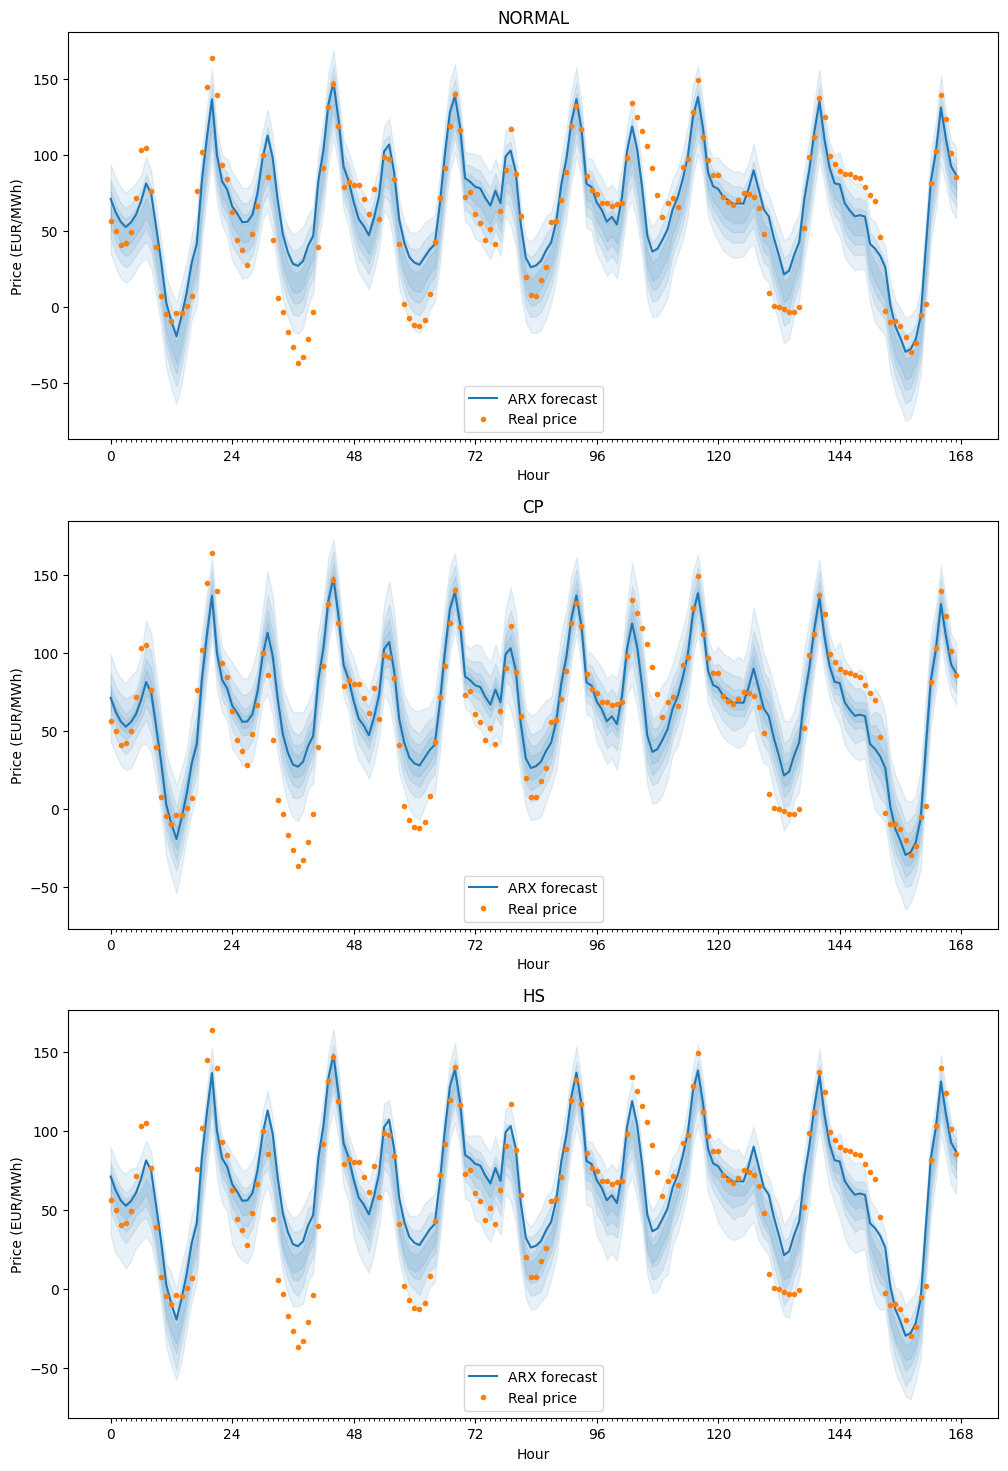

In [15]:
hours = range(0, 24*ndays)
fig, axes = plt.subplots(3, 1, figsize=(12, 18))
models = ['normal', 'cp', 'hs']

for i in range(len(models)):
    model = models[i]
    ax = axes[i]
    # plot ARX forecasts and prediction intervals
    ax.plot(hours, np.array(df['arx_forecast']), label='ARX forecast')

    for alpha in confidence_levels:
        ax.fill_between(hours, np.array(df[f"lower{int(alpha*100)}%_{model}"]), np.array(df[f"upper{int(alpha*100)}%_{model}"]),
                        alpha=0.1, label=None, color='C0')
    # plot real prices
    ax.plot(hours, np.array(df['price']), 'o', label='Real price', markersize=3)

    # format plot
    ax.legend()
    ax.set_title(model.upper())
    ax.set_xlabel('Hour')
    ax.set_ylabel('Price (EUR/MWh)')
    ax.set_xticks(np.arange(0, 24*ndays+1, 24))
    ax.set_xticks(np.arange(0, 24*ndays+1, 1), minor=True)
plt.show()


### Plot the comparison of historical simulation and conformal prediction intervals

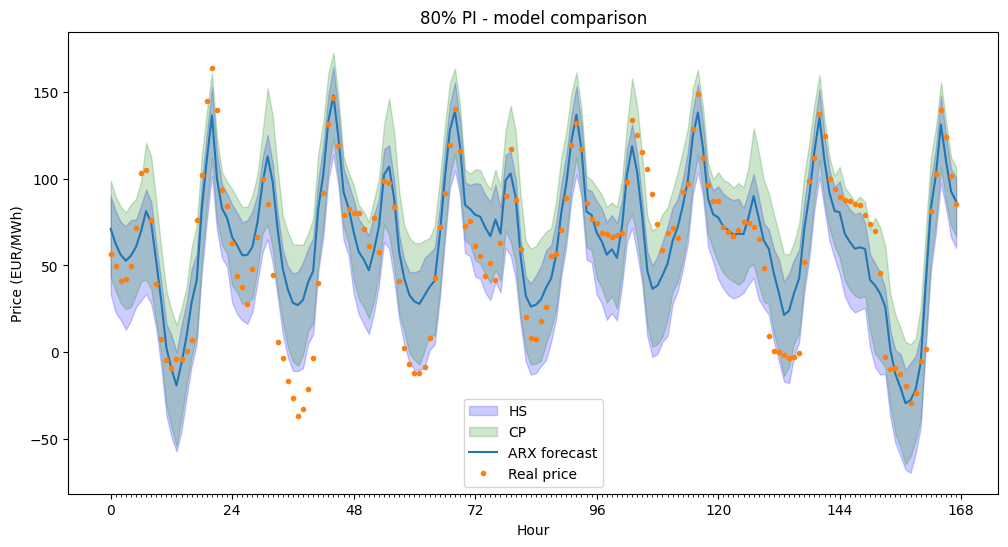

In [16]:
plt.figure(figsize=(12, 6))
hours = range(0, 24*ndays)
models = ['hs', 'cp']
clrs = ["blue", "green"]
for i in range(len(models)):
    model = models[i]
    # plot ARX forecasts and prediction intervals
    plt.fill_between(hours, np.array(df[f"lower80%_{model}"]), np.array(df[f"upper80%_{model}"]),
                        alpha=0.2, label=model.upper(), color = clrs[i])
    # format plot
plt.plot(hours, np.array(df['arx_forecast']), label='ARX forecast', color='C0')
plt.plot(hours, np.array(df['price']), 'o', label='Real price', markersize=3, color='C1')
plt.legend()
plt.title("80% PI - model comparison")
plt.xlabel('Hour')
plt.ylabel('Price (EUR/MWh)')
plt.xticks(np.arange(0, 24*ndays+1, 24))
plt.xticks(np.arange(0, 24*ndays+1, 1), minor=True)
plt.show()